# Data Processing Functions For Thesis

### Packages required

In [0]:
import pandas as pd
import io
import numpy as np
import ast
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
from fancyimpute import KNN, SoftImpute

from scipy import stats
from sklearn.ensemble import IsolationForest

from collections import Counter, OrderedDict
import missingno as msno
import warnings
warnings.filterwarnings('ignore')

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import files

In [0]:

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

### Functions

In [0]:
def convert_dates(col_names, df):
    # input: list of column names and a dataframe
    # output: same dataframe with columns converted to datetimes
    for var in tqdm(col_names):
        df[var] = pd.to_datetime(df[var])
    return df

In [0]:
def drop_cols(col_names, df):
    # input: list of column names and a dataframe
    # output: same dataframe with columns dropped
    df = df.drop(col_names, axis=1)
    return df

In [0]:
def edit_list_var(col_names, df):
    # input: list of column names and a dataframe
    # output: same dataframe with changed list cols
    for var in col_names:
        df[var] = df[var].apply(lambda x: x.split(','))
    return df

In [0]:
def sort_list_vars(col_names, df):
    # input: list of column names and a dataframe
    # output: same dataframe with ordered list cols
    for var in col_names:
        df[var] = df[var].apply(lambda x: sorted(ast.literal_eval(x)))
    return df

In [0]:
def create_count_col(col_names, df):
    # input: list of column names and a dataframe
    # output: dataframe with additional columns of counts
    for var in col_names:
        new_col = var + "_counts"
        df[new_col] = df[var].apply(lambda x: len(set(x)))
    return df

In [0]:
def get_missing_value_perc(df):
    # input: pandas df
    # output: the percetange of missing values in each variable
    percent_missing = df.isna().mean().round(4) * 100
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                   'percent_missing': percent_missing
                                  }
    )
    return missing_value_df

def get_above_missing_threshold(missing_df, th):
    # input: pandas df, threshold
    # output: variables with missing values above a set threshold
    missing_df = missing_df[missing_df['percent_missing'] > th]
    return missing_df

In [0]:
def get_df_percentage(df, var, value):
    # input: dataframe, variable name, and value of variable
    # output: percent of clients that value that the var that has defautled
    df_var = df[[var,'defaulted']]
    def_var = np.float(len(df_var[df_var['defaulted'] == 1]))
    paid_var = np.float(len(df_var[df_var['defaulted'] != 1]))
    if str(value)=='nan':
        def_level = np.float(len(df[(pd.isnull(df[var])) & (df['defaulted'] == 1)]))
        paid_level = np.float(len(df[(pd.isnull(df[var])) & (df['defaulted'] != 1)]))
    else:
        def_level = np.float(len(df[(df[var] == value) & (df['defaulted'] == 1)]))
        paid_level = np.float(len(df[(df[var] == value) & (df['defaulted'] != 1)]))
    if def_level==0:
        def_level+=1
    return def_level, paid_level, def_var, paid_var

def woe(df, var):
    # input: dataframe, variable name
    # output: scaled verison of the cat variables
    final_rates = []
    unique_values = df[var].unique()
    for val in unique_values:
        defaulted, paid, defaulted_total, paid_total = get_df_percentage(df, var, val)
        final_rates.append([val, np.log((paid/paid_total)/(defaulted/defaulted_total)) * 100])
    return final_rates

In [0]:
def standardize(df):
    # input: a dataframe
    # output: scaled dataframe
    return df.sub(df.min()).div((df.max() - df.min()))

### Read in Data

In [0]:
age_link = drive.CreateFile({'id':'1LMZbDFxcbn37p_nfU8VBdrT6qvqZP8du'}) 
age_link.GetContentFile('age_stats.csv')
age = pd.read_csv('age_stats.csv')

In [0]:
data_link = drive.CreateFile({'id':'1_qKwLiExB8mOpo-95PDGWPKSG8I0M2Vh'}) 
data_link.GetContentFile('applications_with_data_test.csv')
data = pd.read_csv('applications_with_data_test.csv')

In [0]:
data = pd.merge(data, age, how='left', on=['application_id'])
# ensure dates are dates
# data = convert_dates(['application_date', 'disbursement_date', 'approval_date', 'due_date', 'paid_date', 'closed_date'], data)

### Drop Unwanted Columns

In [0]:
data = drop_cols(['Unnamed: 0', 'loan_id', 'client_id', 'application_id','application_date', 'disbursement_date', 'approval_date',
                  'due_date', 'paid_date', 'closed_date', 'loan_number', 'loan_amount', 'term_days', 'interest_rate', 'device_network',
                  'device_data_expense', 'open_accounts_by_status', 'closed_accounts_by_status','employer_name', 'loan_senders', 'competitors_contacted',
                  'credit_providers', 'banks_contacted', 'device', 'payweek', 'check'
                 ], data
                )

### Check Missing Values


In [0]:
bank_cols = {'max_succesful_loan_payment': 0, 'min_succesful_loan_payment': 0,
             'max_unsuccesful_loan_payment': 0, 'min_unsuccesful_loan_payment': 0,
             'max_loan_amount':0}

In [0]:
data = data.fillna(value=bank_cols)

In [0]:
missing = get_missing_value_perc(data)
many_missing = get_above_missing_threshold(missing, 20)
many_missing

,column_name,percent_missing
max_balance,max_balance,21.19
min_balance,min_balance,21.19
max_credit,max_credit,33.05
min_credit,min_credit,33.05
max_debit,max_debit,22.93
min_debit,min_debit,22.93


In [0]:
missing_count = data.isnull().sum(axis=1).tolist()
missing_count = Counter(missing_count)
missing_count = OrderedDict(sorted(missing_count.items()))
missing_count = pd.DataFrame.from_dict(missing_count, orient='index', columns=['Count'])
missing_count['cum_sum'] = missing_count['Count'].cumsum()
missing_count['cum_perc'] = round(100*missing_count['cum_sum']/missing_count['Count'].sum(),2)
missing_count.head(100)

,Count,cum_sum,cum_perc
0,28808,28808,45.77
1,6276,35084,55.75
2,6275,41359,65.72
3,1495,42854,68.09
4,577,43431,69.01
5,97,43528,69.16
6,12500,56028,89.03
7,3516,59544,94.61
8,1168,60712,96.47
9,376,61088,97.07


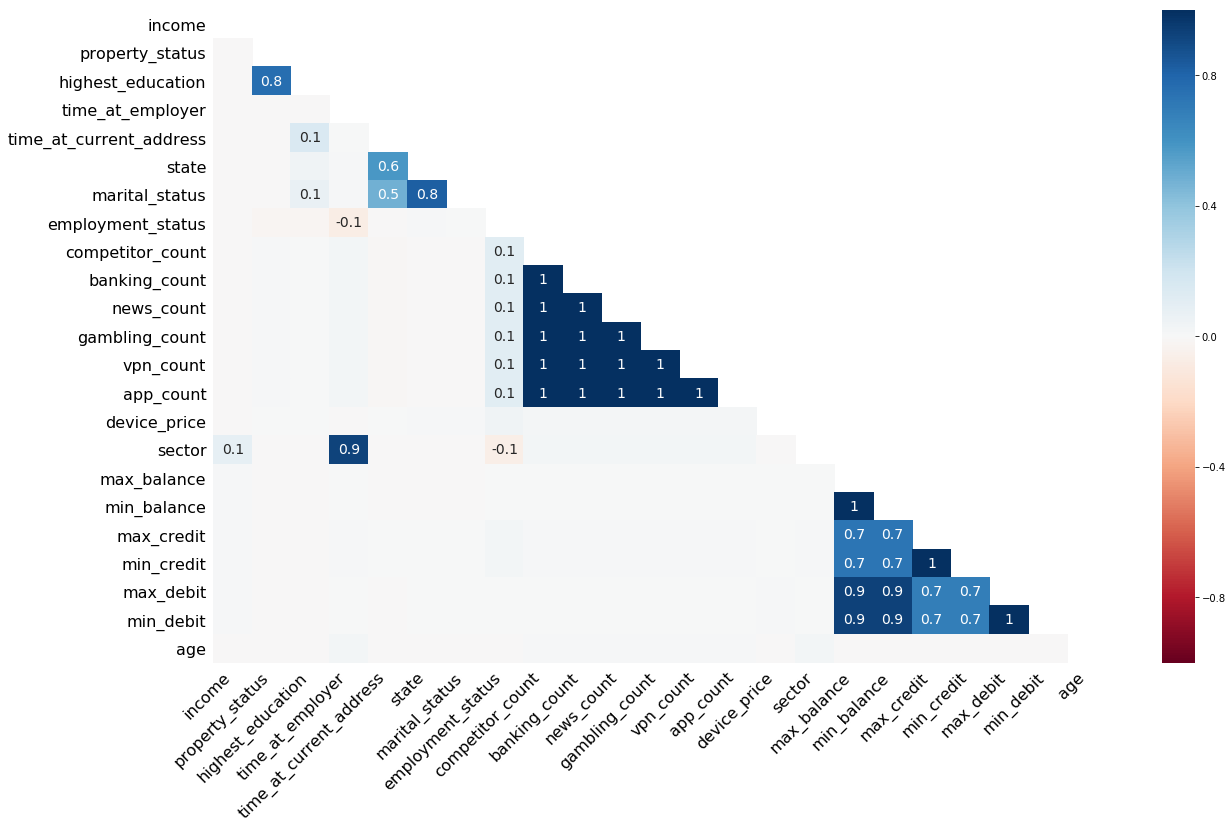

In [0]:
msno.heatmap(data)

### Order the List Variables

In [0]:
# data = edit_list_var(['credit_providers'], data)
# data = sort_list_vars(['banks_contacted', 'competitors_contacted', 'loan_senders'], data)
# data = create_count_col(['banks_contacted', 'competitors_contacted', 'loan_senders', 'credit_providers'], data)

### Isolate Numeric, Categorical and Target Data

In [0]:
num_data = data.select_dtypes(include=['float64','int64'])
cat_data = data.select_dtypes(include=['object'])
target_data = data['defaulted']

### Use Min Max Scaler for Categorical Variables 

In [0]:
for var in list(cat_data):
    rates = []
    if var not in ('application_id', 'banks_contacted', 'competitors_contacted', 'loan_senders', 'credit_providers', 'employer_name'):
      print(var)
      rates = woe(data, var)
      for rate in tqdm(rates):
          cat_data[var] = cat_data[var].replace(rate[0], rate[1])

  0%|          | 0/8 [00:00<?, ?it/s]

property_status


  0%|          | 0/5 [00:00<?, ?it/s]

highest_education


100%|██████████| 5/5 [00:00<00:00,  6.48it/s]


time_at_employer


  0%|          | 0/5 [00:00<?, ?it/s]

loan_purpose


100%|██████████| 5/5 [00:00<00:00,  6.24it/s]


time_at_current_address


100%|██████████| 38/38 [00:05<00:00,  6.33it/s]


state


100%|██████████| 38/38 [00:06<00:00,  6.32it/s]


bank


  0%|          | 0/5 [00:00<?, ?it/s]

marital_status


  0%|          | 0/7 [00:00<?, ?it/s]

employment_status


  0%|          | 0/2 [00:00<?, ?it/s]

gender


  0%|          | 0/8 [00:00<?, ?it/s]

device_brand


100%|██████████| 8/8 [00:01<00:00,  5.88it/s]


sector


  0%|          | 0/4 [00:00<?, ?it/s]

application_time


  0%|          | 0/4 [00:00<?, ?it/s]

application_week


100%|██████████| 4/4 [00:00<00:00,  6.57it/s]


In [0]:
print(cat_data['marital_status'].unique())
print(data['marital_status'].unique())

[-13.16365502   6.54932331  16.1469928   13.82591148  93.79987175]
['Single' 'Married' 'Widowed' 'Separated' nan]


### Merge Standardised Categorical Data and Numeric Data

In [0]:
model_data = pd.merge(num_data,cat_data, left_index=True, right_index=True)
model_data = model_data.where((pd.notnull(model_data)), None)
model_data.head()

,income,time_at_property,num_applications,total_accounts,open_accounts_by_date,closed_accounts_by_date,performing_loans,paid_loans,nonperforming_loans,lost_loans,missed_payments,defaulted,competitor_count,banking_count,news_count,gambling_count,vpn_count,app_count,device_price,max_balance,min_balance,credit_transactions,max_credit,min_credit,debit_transactions,max_debit,min_debit,insufficient_funds,succesful_payments,max_succesful_loan_payment,min_succesful_loan_payment,unsuccesful_payments,max_unsuccesful_loan_payment,min_unsuccesful_loan_payment,rejected_loans,max_loan_amount,age,property_status,highest_education,time_at_employer,loan_purpose,time_at_current_address,state,bank,marital_status,employment_status,gender,device_brand,sector,application_time,application_week
0,50000,116,2,3,2,1,1,0,1,1,20,0,3,1,0,0,1,205,60188,8405.43,7.92,0,None,None,18,3000,20,0,1,2400,2400,2,1350,1350,0,1275,33,-4.80039,-2.90679,17.7142,-29.2243,20.2292,16.8454,-18.2967,-13.1637,5.48577,-7.75883,1.538,4.16524,-0.419383,-3.81469
1,30000,33,12,2,1,1,2,0,0,0,1,1,2,2,0,2,0,195,87250,24216.5,-38.51,8,5000,1000,48,23000,50,0,0,0,0,8,5.10021e+08,-5.10021e+08,0,7026,24,3.0705,-7.26357,-24.8582,25.1538,7.44288,7.09018,7.62806,-13.1637,5.48577,-7.75883,1.538,4.16524,-1.23322,4.59513
2,50000,76,1,3,0,3,3,0,0,0,3,0,3,1,0,0,0,116,33210,103078,14.49,41,100000,3.32,126,92940,30,0,3,2.02e+17,200,0,0,0,0,28175,42,3.0705,-2.90679,0.868152,-16.4695,-3.7967,5.32768,4.82929,6.54932,25.8153,-7.75883,-17.0561,-24.6031,-1.23322,0.436746
3,211000,39,42,19,4,15,14,0,3,2,77,0,4,4,1,0,2,326,80036,671052,-381696,76,615000,30,343,255000,4,0,3,1900,1900,0,0,0,0,65000,30,-4.80039,-2.90679,0.868152,-29.2243,3.84764,16.8454,18.147,6.54932,5.48577,24.0537,15.2296,4.16524,2.96987,0.437604
4,198000,41,1,7,0,7,6,0,1,0,12,0,3,1,0,0,0,109,127350,198524,-36195.6,37,197776,1000,184,100000,1,0,2,2.02e+17,2.02e+17,0,0,0,0,18170,54,3.0705,-2.90679,0.868152,25.2003,3.84764,12.2554,4.82929,16.147,5.48577,-7.75883,-6.5547,4.16524,2.96987,-3.81469


### KKN Imputation

In [0]:
# standardize data
model_data = model_data.apply(standardize, axis=0)
filled_model_data = pd.DataFrame(data=SoftImpute().fit_transform(model_data),columns=model_data.columns, index=model_data.index)

[SoftImpute] Max Singular Value of X_init = 653.549701
[SoftImpute] Iter 1: observed MAE=0.021763 rank=25
[SoftImpute] Iter 2: observed MAE=0.021800 rank=24
[SoftImpute] Iter 3: observed MAE=0.021813 rank=23
[SoftImpute] Iter 4: observed MAE=0.021776 rank=23
[SoftImpute] Iter 5: observed MAE=0.021762 rank=23
[SoftImpute] Iter 6: observed MAE=0.021756 rank=23
[SoftImpute] Iter 7: observed MAE=0.021656 rank=22
[SoftImpute] Iter 8: observed MAE=0.021575 rank=22
[SoftImpute] Iter 9: observed MAE=0.021549 rank=22
[SoftImpute] Iter 10: observed MAE=0.021541 rank=22
[SoftImpute] Iter 11: observed MAE=0.021540 rank=22
[SoftImpute] Iter 12: observed MAE=0.021540 rank=22
[SoftImpute] Iter 13: observed MAE=0.021541 rank=22
[SoftImpute] Iter 14: observed MAE=0.021540 rank=22
[SoftImpute] Iter 15: observed MAE=0.021539 rank=22
[SoftImpute] Iter 16: observed MAE=0.021535 rank=22
[SoftImpute] Iter 17: observed MAE=0.021529 rank=22
[SoftImpute] Iter 18: observed MAE=0.021520 rank=22
[SoftImpute] Iter 

### Outlier Detection




In [0]:
clf = IsolationForest(behaviour = 'new', max_samples=100, random_state = 1, contamination= 'auto')
preds = clf.fit_predict(filled_model_data)
filled_model_data['Outlier'] = preds

### Remove Outliers

In [0]:
final_model_data = filled_model_data[filled_model_data['Outlier']==1]
print('Outlier removed: ', filled_model_data.shape[0]-final_model_data.shape[0])

Outlier removed:  2627


### Export Model Dataset

In [0]:
# final_model_data.to_csv('final_model_data.csv') 
# files.download('final_model_data.csv')
print(final_model_data.shape)

(60307, 52)
